<a href="https://colab.research.google.com/github/Ayanlola2002/Technidus_project/blob/master/Property_ML_for_participants_for_scraped_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import sklearn.model_selection as ms
#from xgboost import XGBClassifier
#from xgboost import XGBRegressor
#from sklearn.ensemble import GradientBoostingRegressor
#import lightgbm as lgbm
import sklearn.metrics as sklm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
%matplotlib inline

In [ ]:
#import datasets

train = pd.read_csv("Lagos_house_data.csv",encoding = "ISO-8859-1")

In [ ]:
#train = train1.merge(train2,how="left",on='row_id')
train.head()

,location,location_s,features,bath,bed,toilet,price,description,page,loc
0,sosanya soluyi gbagada lagos,sosanya soluyi,3 bed 2 bath 3 toilet,2,3,3,850000,3 bedroom Flat / Apartment for rent Sosanya So...,1,gbagada
1,millenuim ups gbagada lagos,millenuim ups,1 bed 1 bath 1 toilet,1,1,1,650000,1 bedroom mini flat Mini flat Flat / Apartment...,1,gbagada
2,alapere gbagada lagos,alapere,2 bed 2 bath 2 toilet,2,2,2,600000,"2bed at Alapere, all rooms ensuit ... ...",1,gbagada
3,medina gbagada lagos,medina,3 bed 3 bath 4 toilet,3,3,4,1500000,3 bedroom Flat / Apartment for rent Medina Gba...,1,gbagada
4,adeola atunrase medina gbagada lagos,adeola atunrase medina,3 bed 3 bath 3 toilet,3,3,3,1500000,3 bedroom House for rent Adeola Atunrase Medin...,1,gbagada


In [ ]:
train.columns

Index(['location', 'location_s', 'features', 'bath', 'bed', 'toilet', 'price',
       'description', 'page', 'loc'],
      dtype='object')

In [ ]:
#Change coluumns names
train.columns = ['spec_location','location_s','features','bathrooms','bedrooms','toilets','price','description','page','location']

In [ ]:
#Subset the data to capture only relevant columns
train = train[['bedrooms','bathrooms','toilets','description',
               'location','spec_location','price']]

In [ ]:
#Inspect dataframe
train.shape

(5188, 7)

In [ ]:
#check for null values
train.isnull().sum()

bedrooms         0
bathrooms        0
toilets          0
description      0
location         0
spec_location    0
price            0
dtype: int64

In [ ]:
#convert price to numeric from string
train2 = train.copy()
train2 ['price']= pd.to_numeric(train2['price'],errors = 'coerce')  #.str.strip().replace(",","").replace("$","").astype(float)

In [ ]:
#Fill Price NAs after conversion
train2['price']=train2['price'].fillna(0)

In [ ]:
#Subset data to ensure only data with price >0 is used
train2 = train2[train2['price']!=0]

In [ ]:
#convert house details to numeric from string just like price
train2 ['bedrooms']= pd.to_numeric(train2['bedrooms'],errors = 'coerce')
train2 ['bathrooms']= pd.to_numeric(train2['bathrooms'],errors = 'coerce')
train2 ['toilets']= pd.to_numeric(train2['toilets'],errors = 'coerce')

In [ ]:
#Fill NAs after conversion
train2['bedrooms']=train2['bedrooms'].fillna(0)
train2['bathrooms']=train2['bathrooms'].fillna(0)
train2['toilets']=train2['toilets'].fillna(0)

In [ ]:
#Subset data to ensure only data with values >0 is used
train2 = train2[(train2['bedrooms']!=0) | (train2['bathrooms'] !=0) | (train2['toilets']!=0)]

In [ ]:
#Inspect new shape
train2.shape

(4945, 7)

In [ ]:
#create new features
train2['estate_flag'] = train2['description'].apply(lambda x: len([c for c in str(x).lower().split() if "estate" in c]))
train2['terrace_flag'] = train2['description'].apply(lambda x: len([c for c in str(x).lower().split() if "terraced" 
                                                                  in c or "terrace" in c or "detached" in c
                                                                 or "duplex" in c]))
train2['new_flag'] = train2['description'].apply(lambda x: len([c for c in str(x).lower().split()
                                                              if "new" in c or "luxur" in c 
                                                              or "executive" in c]))
train2['serviced_flag'] = train2['description'].apply(lambda x: len([c for c in str(x).lower().split() if "service" in c]))

In [ ]:
#Convert new features to 1 and 0 by allocating values greater than 1 to 1
#The features were created by using a count(len) this means some rows may have a value greater than 1
train2['estate_flag'][train2['estate_flag']>=1] = 1
train2['terrace_flag'][train2['terrace_flag']>=1] = 1
train2['serviced_flag'][train2['serviced_flag']>=1] = 1
train2['new_flag'][train2['new_flag']>=1] = 1

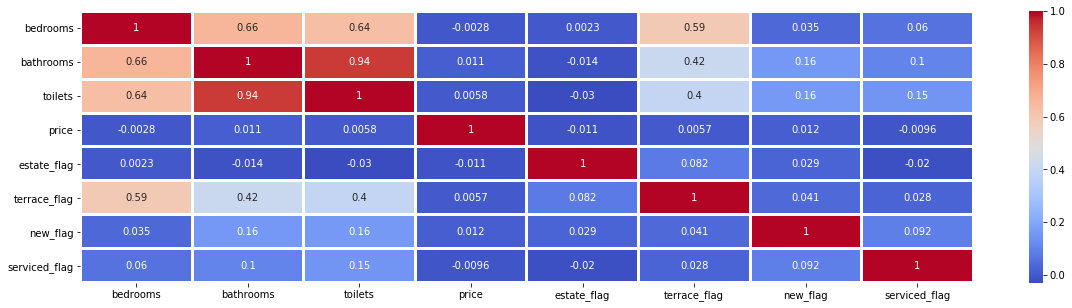

In [ ]:
#Check correlations
corr= train2.corr()
#corr
f, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corr,cmap='coolwarm',linewidths=2.0, annot=True)

In [ ]:
corr

,bedrooms,bathrooms,toilets,price,estate_flag,terrace_flag,new_flag,serviced_flag
bedrooms,1.000000,0.664077,0.635505,-0.002764,0.002256,0.594304,0.035459,0.059701
bathrooms,0.664077,1.000000,0.935947,0.011467,-0.014470,0.415974,0.158246,0.103827
toilets,0.635505,0.935947,1.000000,0.005849,-0.029831,0.396510,0.159454,0.149259
price,-0.002764,0.011467,0.005849,1.000000,-0.011016,0.005656,0.012363,-0.009595
estate_flag,0.002256,-0.014470,-0.029831,-0.011016,1.000000,0.081675,0.028634,-0.019682
terrace_flag,0.594304,0.415974,0.396510,0.005656,0.081675,1.000000,0.040726,0.028112
new_flag,0.035459,0.158246,0.159454,0.012363,0.028634,0.040726,1.000000,0.091678
serviced_flag,0.059701,0.103827,0.149259,-0.009595,-0.019682,0.028112,0.091678,1.000000


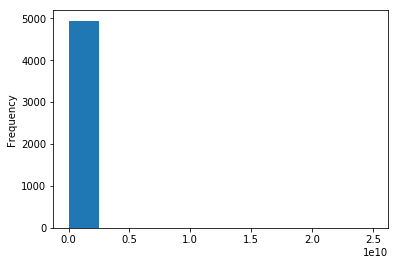

In [ ]:
#Examine distribution of all houses to identify outliers
train2['price'].plot("hist")

In [ ]:
#Define a threshold based on percentile to avoid hardcoding
threshold = np.percentile(train2['price'],90)
threshold

8000000.0

In [ ]:
#Inspect prices greater than the threshold 
train2[train2['price']<=threshold].sort_values('price',ascending = False)

,bedrooms,bathrooms,toilets,description,location,spec_location,price,estate_flag,terrace_flag,new_flag,serviced_flag
1815,2,2.0,3.0,** Furnished 2 bedroom flat with excellent ser...,ikoyi,cameron green ikoyi lagos,8000000.0,0,0,1,1
1917,3,4.0,4.0,*3 BEDROOM WATERFRONT LUXURY APARTMENTS FOR SA...,ikoyi,banana island ikoyi lagos,8000000.0,0,1,1,1
1914,5,5.0,5.0,Luxurious and exquisitely finished 5bedroom de...,ikoyi,banana island ikoyi lagos,8000000.0,0,1,1,0
1390,4,4.0,5.0,A newly built four bedroom duplex in a private...,ikeja,mobolaji bank anthony way ikeja lagos,8000000.0,1,1,1,0
1397,5,5.0,6.0,Letting: Exquisitely finished 5 Bedroom Semi-d...,ikeja,ikeja gra ikeja lagos,8000000.0,0,1,1,0
1897,3,4.0,4.0,*3 BEDROOM WATERFRONT LUXURY APARTMENTS FOR SA...,ikoyi,banana island ikoyi lagos,8000000.0,0,1,1,1
3042,7,7.0,8.0,7bedroom fully detached duplex with 2rooms bq ...,lekki,lekki phase 1 lekki lagos,8000000.0,0,1,0,0
2165,3,3.0,4.0,FOR RENT Banana island Lagos 3 bedroom all roo...,ikoyi,residential zone banana island ikoyi lagos,8000000.0,0,0,1,1
4688,5,5.0,6.0,Spacious Commercial 5 Bedroom Semi Detached Du...,lekki,lekki phase 1 lekki lagos,8000000.0,0,1,0,0
1882,3,3.0,4.0,3 bedroom Flat / Apartment for rent Banana Isl...,ikoyi,banana island ikoyi lagos,8000000.0,0,0,1,1


In [ ]:
#Notice that some of the houses are actually for sale 
#and not rent hence the reason for the high price

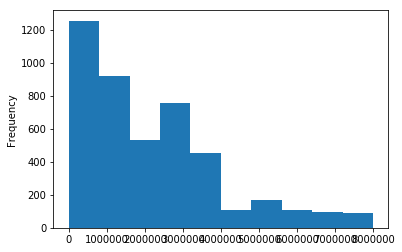

In [ ]:
#Examine distribution of all houses to identify outliers
train2['price'][train2['price']<=threshold].plot("hist")

In [ ]:
#Subset to eliminate outliers
train2 = train2[train2['price']<=threshold]

In [ ]:
#check shape
train2.shape

(4488, 11)

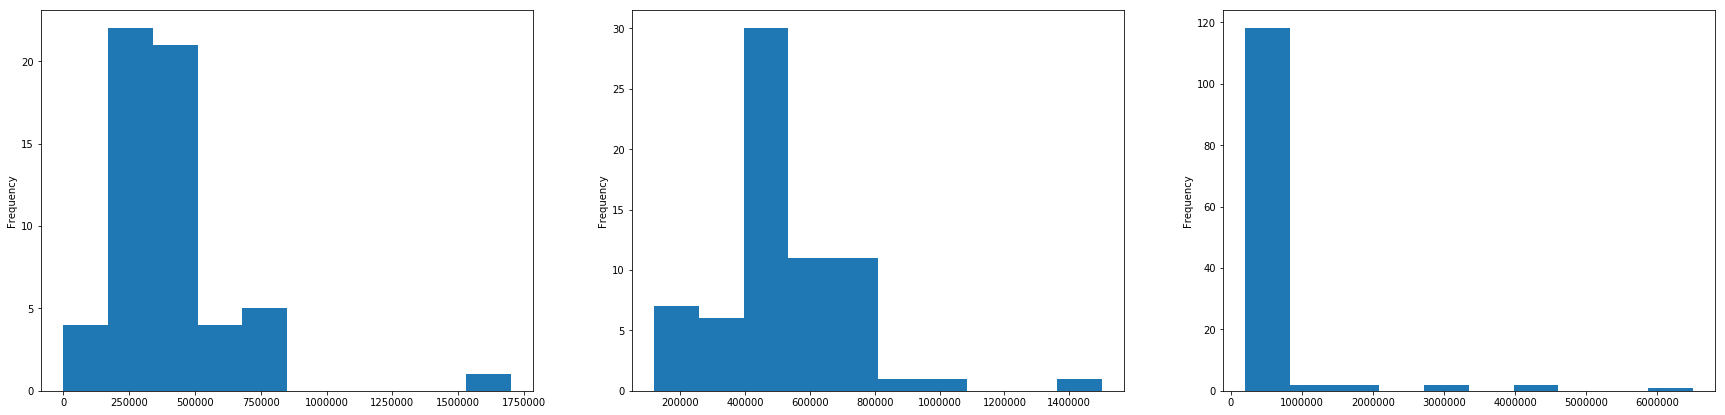

In [ ]:
#Inspect the distribution of houses per location and size of house
locations = list(train2['location'].unique())

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,7))
fig.add_subplot(1, 3, 1)
train2['price'][(train2['location']==locations[0])&(train2['bedrooms']==1)].plot("hist")
fig.add_subplot(1, 3, 2)
train2['price'][(train2['location']==locations[1])&(train2['bedrooms']==1)].plot("hist")
fig.add_subplot(1, 3, 3)
train2['price'][(train2['location']==locations[2])&(train2['bedrooms']==1)].plot("hist")

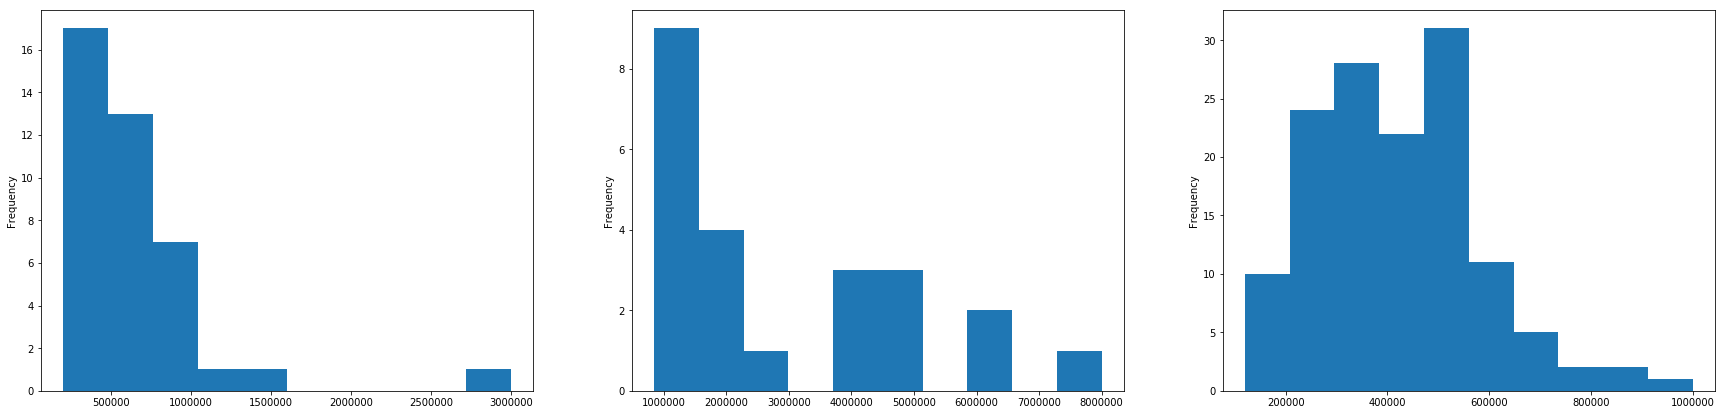

In [ ]:
#Inspect the distribution of houses per location and size of house
locations = list(train2['location'].unique())

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,7))
fig.add_subplot(1, 3, 1)
train2['price'][(train2['location']==locations[6])&(train2['bedrooms']==1)].plot("hist")
fig.add_subplot(1, 3, 2)
train2['price'][(train2['location']==locations[7])&(train2['bedrooms']==1)].plot("hist")
fig.add_subplot(1, 3, 3)
train2['price'][(train2['location']==locations[8])&(train2['bedrooms']==1)].plot("hist")

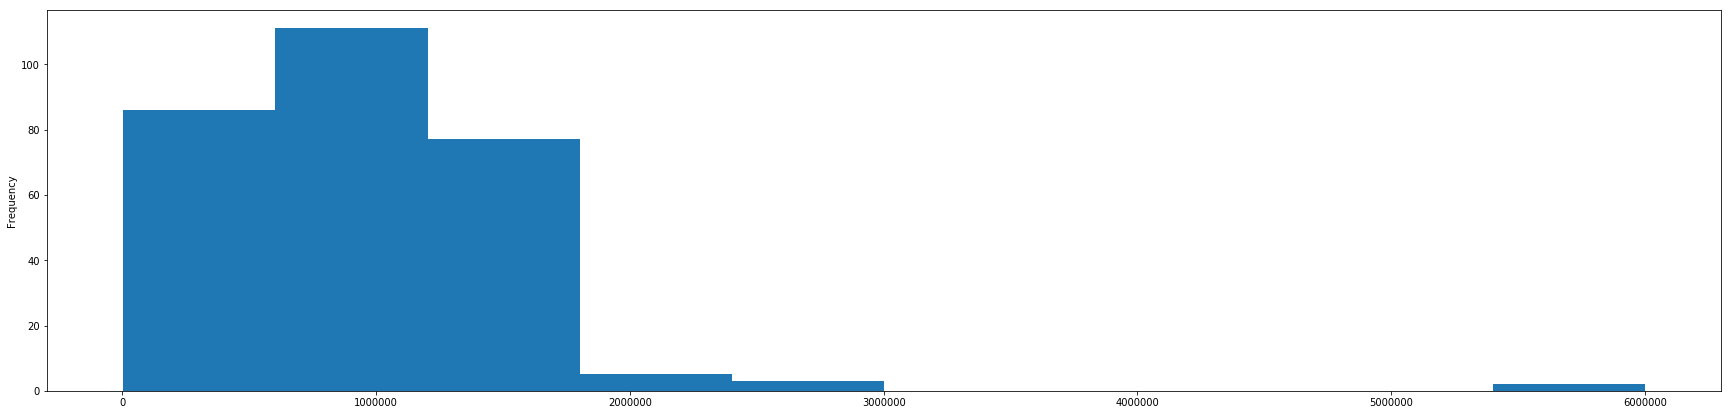

In [ ]:
#Inspect the distribution of houses per location and size of house
locations = list(train2['location'].unique())

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(30,7))
#fig.add_subplot(1, 1, 1)
train2['price'][(train2['location']==locations[9])&(train2['bedrooms']==1)].plot("hist")

In [ ]:
#Since some houses may have missing info it means some estate/serviced houses are not called estate/serviced houses. 
#Assumptions are made around houses which are not identified as estate/ service houses. 
#The median/50th percentile of those houses is identified and any house above the median is considered as estate.
#Houses higher than 80th percentile are classified as serviced


estate_price = []
import numpy as np
for location in locations:
    for i in range(1,6):
        d = {}
        d['location'] = location
        d['bedspace'] = i
        try:
            d['estate_price'] = np.percentile(train2['price'][(train2['location']==location)&(train2['bedrooms']==i)&(train2['estate_flag']==0)],50)
            d['serviced_price'] = np.percentile(train2['price'][(train2['location']==location)&(train2['bedrooms']==i)&(train2['estate_flag']==0)],80)
        except (IndexError,TypeError) as e:
            d['serviced_price'] = 0
            d['estate_price'] = 0
        estate_price.append(d)
        try:
            print("This is the median for {bed} bedroom in {location} : ".format(bed = i,location = location) ,np.percentile(train2['price'][(train2['location']==location)&(train2['bedrooms']==i)&(train2['estate_flag']==0)],50))
        except (IndexError,TypeError) as e:
            print("This is the median for {bed} bedroom in {location} : ".format(bed = i,location = location) ,0)

This is the median for 1 bedroom in gbagada :  400000.0
This is the median for 2 bedroom in gbagada :  800000.0
This is the median for 3 bedroom in gbagada :  1300000.0
This is the median for 4 bedroom in gbagada :  2000000.0
This is the median for 5 bedroom in gbagada :  0
This is the median for 1 bedroom in surulere :  500000.0
This is the median for 2 bedroom in surulere :  750000.0
This is the median for 3 bedroom in surulere :  1200000.0
This is the median for 4 bedroom in surulere :  2500000.0
This is the median for 5 bedroom in surulere :  3500000.0
This is the median for 1 bedroom in yaba :  450000.0
This is the median for 2 bedroom in yaba :  800000.0
This is the median for 3 bedroom in yaba :  1300000.0
This is the median for 4 bedroom in yaba :  2000000.0
This is the median for 5 bedroom in yaba :  1750000.0
This is the median for 1 bedroom in ikorodu :  120000.0
This is the median for 2 bedroom in ikorodu :  250000.0
This is the median for 3 bedroom in ikorodu :  300000.0
T

In [ ]:
#save the output in a dataframe and in order to merge with original dataframe
estate_price=pd.DataFrame(estate_price)
estate_price['locationbed'] = estate_price['location'] + estate_price['bedspace'].astype(str)
estate_price = estate_price.drop(["location","bedspace"],axis=1)

In [ ]:
estate_price.head()

,estate_price,serviced_price,locationbed
0,400000.0,560000.0,gbagada1
1,800000.0,1060000.0,gbagada2
2,1300000.0,1840000.0,gbagada3
3,2000000.0,2300000.0,gbagada4
4,0.0,0.0,gbagada5


In [ ]:
#merge to original dataframe to create new dataframe
train2['locationbed']  = train2 ['location'] + train2 ['bedrooms'].astype(str)
train3 = pd.merge(train2,estate_price, on ="locationbed", how = "left")

In [ ]:
#identify estate houses that were not called estate houses by assigning houses greater than median as estate houses
#identify serviced houses that were not called serviced houses by assigning houses greater than 80th percentile as serviced houses
#terrace houses are typically greater than 1.8m based on distribution
train3['estate_flag'][(train3['bedrooms']==1)&(train3['price'] > train3['estate_price'])] = 1
train3['estate_flag'][(train3['bedrooms']==2)&(train3['price'] > train3['estate_price'])] = 1
train3['estate_flag'][(train3['bedrooms']==3)&(train3['price'] > train3['estate_price'])] = 1
train3['estate_flag'][(train3['bedrooms']==4)&(train3['price'] > train3['estate_price'])] = 1
train3['estate_flag'][(train3['bedrooms']==5)&(train3['price'] > train3['estate_price'])] = 1
train3['serviced_flag'][(train3['bedrooms']==1)&(train3['price'] > train3['serviced_price'])] = 1
train3['serviced_flag'][(train3['bedrooms']==2)&(train3['price'] > train3['serviced_price'])] = 1
train3['serviced_flag'][(train3['bedrooms']==3)&(train3['price'] > train3['serviced_price'])] = 1
train3['serviced_flag'][(train3['bedrooms']==4)&(train3['price'] > train3['serviced_price'])] = 1
train3['serviced_flag'][(train3['bedrooms']==5)&(train3['price'] > train3['serviced_price'])] = 1

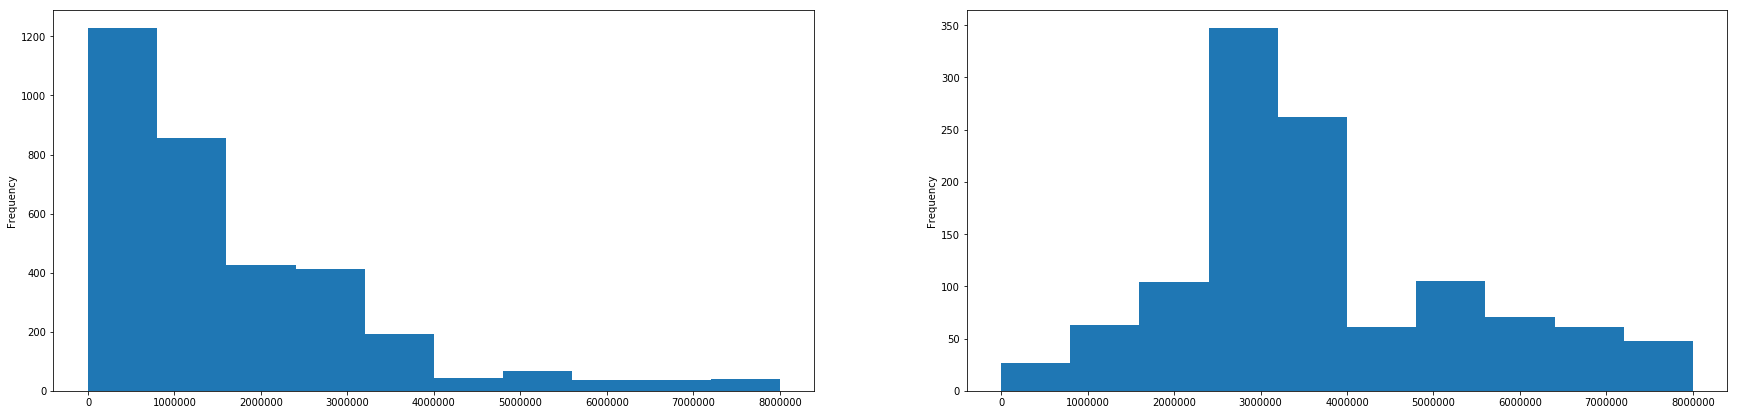

In [ ]:
#inspect houses that are terrace/duplex/detached to see if they are typically higher 
fig = plt.figure(figsize=(30,7))
fig.add_subplot(1, 2, 1)
train3['price'][train3['terrace_flag']==0].plot("hist")
fig.add_subplot(1, 2, 2)
train3['price'][train3['terrace_flag']==1].plot("hist")

In [ ]:
#check to find out if Terrace/duplex/detached houses are higher than normal houses on average
for location in locations:
    for i in range(2,6):
        
        try:
            print("This is the median for a normal {bed} bedroom in {location} : ".format(bed = i,location = location) ,np.percentile(train2['price'][(train2['location']==location)&(train2['bedrooms']==i)&(train2['terrace_flag']==0)],50))
        except (IndexError,TypeError) as e:
            print("This is the median for a normal {bed} bedroom in {location} : ".format(bed = i,location = location) ,0)
        try:
            print("This is the median for a terraced {bed} bedroom in {location} : ".format(bed = i,location = location) ,np.percentile(train2['price'][(train2['location']==location)&(train2['bedrooms']==i)&(train2['terrace_flag']==1)],50))
        except (IndexError,TypeError) as e:
            print("This is the median for a terraced {bed} bedroom in {location} : ".format(bed = i,location = location) ,0)

This is the median for a normal 2 bedroom in gbagada :  950000.0
This is the median for a terraced 2 bedroom in gbagada :  2500000.0
This is the median for a normal 3 bedroom in gbagada :  1500000.0
This is the median for a terraced 3 bedroom in gbagada :  2000000.0
This is the median for a normal 4 bedroom in gbagada :  0
This is the median for a terraced 4 bedroom in gbagada :  2500000.0
This is the median for a normal 5 bedroom in gbagada :  0
This is the median for a terraced 5 bedroom in gbagada :  2400000.0
This is the median for a normal 2 bedroom in surulere :  775000.0
This is the median for a terraced 2 bedroom in surulere :  1600000.0
This is the median for a normal 3 bedroom in surulere :  1200000.0
This is the median for a terraced 3 bedroom in surulere :  2250000.0
This is the median for a normal 4 bedroom in surulere :  2500000.0
This is the median for a terraced 4 bedroom in surulere :  2500000.0
This is the median for a normal 5 bedroom in surulere :  2000000.0
This is

In [ ]:
#The above shows that they are.
#Since some houses may have missing info it means some terrace houses are not called terrace houses. 
#Assumptions are made around houses which are not identified as terrace houses. 
#The median/50th percentile of houses which are terrace is identified and any house = or above the median is considered terrace.

terrace_price = []
import numpy as np
for location in locations:
    for i in range(2,6):
        d = {}
        d['location'] = location
        d['bedspace'] = i
        try:
            d['terrace_price'] = np.percentile(train2['price'][(train2['location']==location)&(train2['bedrooms']==i)&(train2['terrace_flag']==1)],50)    
        except (IndexError,TypeError) as e:
            d['terrace_price'] = 0
        terrace_price.append(d)
        try:
            print("This is the median for a terrace {bed} bedroom in {location} : ".format(bed = i,location = location) ,np.percentile(train2['price'][(train2['location']==location)&(train2['bedrooms']==i)&(train2['terrace_flag']==1)],50))
        except (IndexError,TypeError) as e:
            print("This is the median for a terrace {bed} bedroom in {location} : ".format(bed = i,location = location) ,0)

This is the median for a terrace 2 bedroom in gbagada :  2500000.0
This is the median for a terrace 3 bedroom in gbagada :  2000000.0
This is the median for a terrace 4 bedroom in gbagada :  2500000.0
This is the median for a terrace 5 bedroom in gbagada :  2400000.0
This is the median for a terrace 2 bedroom in surulere :  1600000.0
This is the median for a terrace 3 bedroom in surulere :  2250000.0
This is the median for a terrace 4 bedroom in surulere :  2500000.0
This is the median for a terrace 5 bedroom in surulere :  3750000.0
This is the median for a terrace 2 bedroom in yaba :  0
This is the median for a terrace 3 bedroom in yaba :  2500000.0
This is the median for a terrace 4 bedroom in yaba :  3200000.0
This is the median for a terrace 5 bedroom in yaba :  2000000.0
This is the median for a terrace 2 bedroom in ikorodu :  435000.0
This is the median for a terrace 3 bedroom in ikorodu :  500000.0
This is the median for a terrace 4 bedroom in ikorodu :  800000.0
This is the me

In [ ]:
#save the output in a dataframe and in order to merge with original dataframe
terrace_price=pd.DataFrame(terrace_price)
terrace_price['locationbed'] = terrace_price['location'] + terrace_price['bedspace'].astype(str)
terrace_price = terrace_price.drop(["location","bedspace"],axis=1)
terrace_price.head()

,terrace_price,locationbed
0,2500000.0,gbagada2
1,2000000.0,gbagada3
2,2500000.0,gbagada4
3,2400000.0,gbagada5
4,1600000.0,surulere2


In [ ]:
#merge to original dataframe to create new dataframe
train3 = pd.merge(train3,terrace_price, on ="locationbed", how = "left")

In [ ]:
#identify terrace houses that were not called terrace houses by assigning houses greater than median as terrace houses
#Terrace housese are typically from 2 bedroom
train3['terrace_flag'][(train3['bedrooms']==2)&(train3['price'] > train3['terrace_price'])] = 1
train3['terrace_flag'][(train3['bedrooms']==3)&(train3['price'] > train3['terrace_price'])] = 1
train3['terrace_flag'][(train3['bedrooms']==4)&(train3['price'] > train3['terrace_price'])] = 1
train3['terrace_flag'][(train3['bedrooms']==5)&(train3['price'] > train3['terrace_price'])] = 1

In [ ]:
#Location is not giving the best results as a feature, however merging location and number of beds and ranking that 
#gives your model a better and stronger feature because the lower the rank, the lower the price.
g = train3.groupby(['location','bedrooms'])['price'].median().reset_index().sort_values('price')
g['location_rank']= g['price'].rank()#np.linspace(1,14,14)
g['location_rank'] = g['location_rank'].astype(int)
g['locationbed'] = g['location'] + g ['bedrooms'].astype(str)
g = g.drop(["price","location","bedrooms"],axis=1)
g
#.columns

,location_rank,locationbed
22,1,ikorodu0
23,2,ikorodu1
33,3,iyanaipaja1
24,4,ikorodu2
7,5,gbagada0
46,6,ogba1
59,7,yaba0
36,9,iyanaipaja4
25,9,ikorodu3
8,9,gbagada1


In [ ]:
#merge to dataframe
train3 = pd.merge(train3,g, on ="locationbed", how = "left")

In [ ]:
train3.shape

(4488, 16)

In [ ]:
train3.columns

Index(['bedrooms', 'bathrooms', 'toilets', 'description', 'location',
       'spec_location', 'price', 'estate_flag', 'terrace_flag', 'new_flag',
       'serviced_flag', 'locationbed', 'estate_price', 'serviced_price',
       'terrace_price', 'location_rank'],
      dtype='object')

In [ ]:
#make similar assumptions for new/luxurious/executive houses which were not classified as that
new_price = []
import numpy as np
for location in locations:
    for i in range(1,6):
        d = {}
        d['location'] = location
        d['bedspace'] = i
        try:
            d['estate_price'] = np.percentile(train2['price'][(train2['location']==location)&(train2['bedrooms']==i)&(train2['estate_flag']==0)],50)
            d['new_price'] = np.percentile(train2['price'][(train2['location']==location)&(train2['bedrooms']==i)&(train2['estate_flag']==0)],80)
        except (IndexError,TypeError) as e:
            d['new_price'] = 0
            d['estate_price'] = 0
        new_price.append(d)
        try:
            print("This is the median for {bed} bedroom in {location} : ".format(bed = i,location = location) ,np.percentile(train2['price'][(train2['location']==location)&(train2['bedrooms']==i)&(train2['estate_flag']==0)],80))
        except (IndexError,TypeError) as e:
            print("This is the median for {bed} bedroom in {location} : ".format(bed = i,location = location) ,0)

This is the median for 1 bedroom in gbagada :  560000.0000000001
This is the median for 2 bedroom in gbagada :  1060000.0
This is the median for 3 bedroom in gbagada :  1840000.0000000005
This is the median for 4 bedroom in gbagada :  2300000.0
This is the median for 5 bedroom in gbagada :  0
This is the median for 1 bedroom in surulere :  660000.0000000001
This is the median for 2 bedroom in surulere :  1040000.0000000002
This is the median for 3 bedroom in surulere :  1500000.0
This is the median for 4 bedroom in surulere :  2500000.0
This is the median for 5 bedroom in surulere :  3800000.0
This is the median for 1 bedroom in yaba :  600000.0
This is the median for 2 bedroom in yaba :  1000000.0
This is the median for 3 bedroom in yaba :  1800000.0
This is the median for 4 bedroom in yaba :  3000000.0
This is the median for 5 bedroom in yaba :  1900000.0
This is the median for 1 bedroom in ikorodu :  150000.0
This is the median for 2 bedroom in ikorodu :  360000.0
This is the median

In [ ]:
new_price = pd.DataFrame(new_price)
new_price['locationbed'] = new_price['location'] + new_price['bedspace'].astype(str)
new_price = new_price.drop(["estate_price","location","bedspace"],axis=1)
new_price

,new_price,locationbed
0,560000.0,gbagada1
1,1060000.0,gbagada2
2,1840000.0,gbagada3
3,2300000.0,gbagada4
4,0.0,gbagada5
5,660000.0,surulere1
6,1040000.0,surulere2
7,1500000.0,surulere3
8,2500000.0,surulere4
9,3800000.0,surulere5


In [ ]:
#train2['locationbed']  = train2 ['location'] + train2 ['bedrooms'].astype(str)
train3 = pd.merge(train3,new_price, on ="locationbed", how = "left")

In [ ]:
train3.shape

(4488, 17)

In [ ]:
#assign houses to new/luxurious/executive based on price
train3['new_flag'][(train3['bedrooms']==1)&(train3['price'] > train3['new_price'])] = 1
train3['new_flag'][(train3['bedrooms']==2)&(train3['price'] > train3['new_price'])] = 1
train3['new_flag'][(train3['bedrooms']==3)&(train3['price'] > train3['new_price'])] = 1
train3['new_flag'][(train3['bedrooms']==4)&(train3['price'] > train3['new_price'])] = 1
train3['new_flag'][(train3['bedrooms']==5)&(train3['price'] > train3['new_price'])] = 1

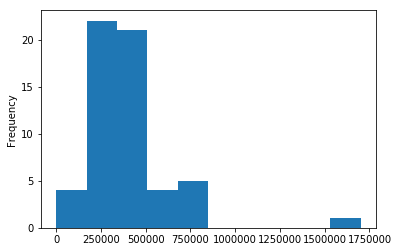

In [ ]:
#Conduct additional inspoection for each location and type of house
import matplotlib.pyplot as plt
train2['price'][(train2['location']=="gbagada")&(train2['bedrooms']==1)].plot("hist")

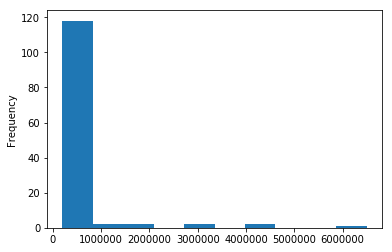

In [ ]:
import matplotlib.pyplot as plt
train2['price'][(train2['location']=="yaba")&(train2['bedrooms']==1)].plot("hist")

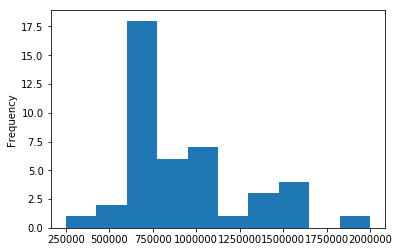

In [ ]:
import matplotlib.pyplot as plt
train2['price'][(train2['location']=="surulere")&(train2['bedrooms']==2)].plot("hist")

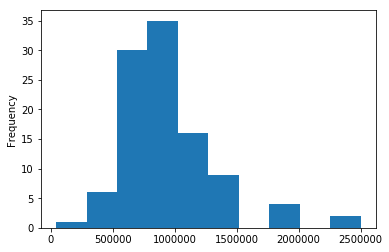

In [ ]:
import matplotlib.pyplot as plt
train2['price'][(train2['location']=="gbagada")&(train2['bedrooms']==2)].plot("hist")

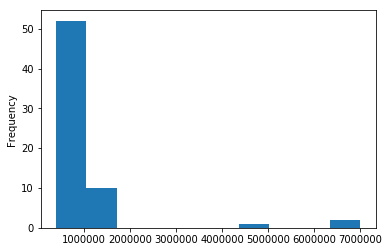

In [ ]:
import matplotlib.pyplot as plt
train2['price'][(train2['location']=="yaba")&(train2['bedrooms']==2)].plot("hist")

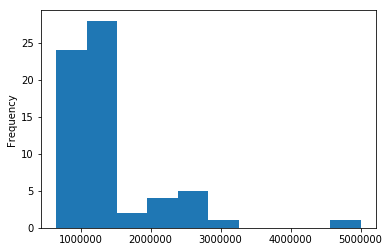

In [ ]:
import matplotlib.pyplot as plt
train2['price'][(train2['location']=="surulere")&(train2['bedrooms']==3)].plot("hist")

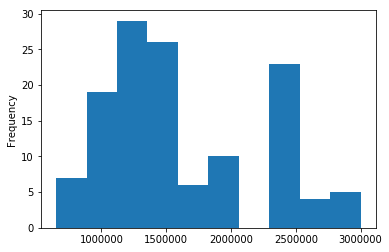

In [ ]:
import matplotlib.pyplot as plt
train2['price'][(train2['location']=="gbagada")&(train2['bedrooms']==3)].plot("hist")

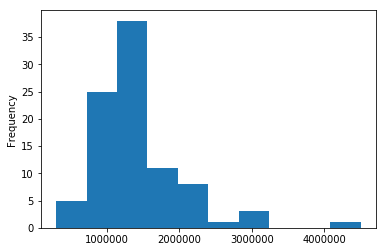

In [ ]:
import matplotlib.pyplot as plt
train2['price'][(train2['location']=="yaba")&(train2['bedrooms']==3)].plot("hist")

In [ ]:
#The distribution has a wide variation. It is possible type of area also determines price. We can make a feature for thsi
#create a feature that determines type of area a house is in based on price. 1 being lowest and 4 being highest type of area
train3['exec_flag']=1

for i in range(0,len(locations)):
    
    train3['exec_flag'][(train3['bedrooms']==3)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],35))]= 2
    train3['exec_flag'][(train3['bedrooms']==3)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],65))]= 3
    train3['exec_flag'][(train3['bedrooms']==3)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],80))]= 4

In [ ]:
for i in range(0,len(locations)):
    train3['exec_flag'][(train3['bedrooms']==2)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],35))]= 2
    train3['exec_flag'][(train3['bedrooms']==2)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],65))]= 3
    train3['exec_flag'][(train3['bedrooms']==2)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],80))]= 4

In [ ]:
for i in range(0,len(locations)):
    train3['exec_flag'][(train3['bedrooms']==1)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],35))]= 2
    train3['exec_flag'][(train3['bedrooms']==1)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],65))]= 3
    train3['exec_flag'][(train3['bedrooms']==1)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],80))]= 4

In [ ]:
for i in range(0,len(locations)):
    train3['exec_flag'][(train3['bedrooms']==4)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],35))]= 2
    train3['exec_flag'][(train3['bedrooms']==4)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],65))]= 3
    train3['exec_flag'][(train3['bedrooms']==4)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],80))]= 4

In [ ]:
for i in range(0,len(locations)):
    train3['exec_flag'][(train3['bedrooms']==5)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],35))]= 2
    train3['exec_flag'][(train3['bedrooms']==5)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],65))]= 3
    train3['exec_flag'][(train3['bedrooms']==5)&(train3['location']==locations[i]) & (train3['price']>= np.percentile(train3['price'],80))]= 4

In [ ]:
#72%
X = train3[['bedrooms','bathrooms', 'toilets', 'estate_flag','location_rank', 'terrace_flag', 'new_flag','exec_flag' ,'serviced_flag']]
y = train3['price']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

x_train, x_cv, y_train, y_cv = train_test_split(X,y, test_size =0.2,random_state = 2)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import r2_score
from math import sqrt

In [ ]:
from sklearn.ensemble import RandomForestRegressor
model1 = RandomForestRegressor(random_state=1, max_depth=11,n_estimators= 1400)
model1.fit(x_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=None,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [ ]:
pred_cv = model1.predict(x_cv)
score = sqrt(mean_squared_error(y_cv,pred_cv))
print('mean_squared_error',score)

mean_squared_error 494287.3194985091


In [ ]:
from sklearn.externals import joblib
joblib.dump(model1, 'modelrf.pkl')
modelza= joblib.load('modelrf.pkl')

In [ ]:
train3.to_csv("clean_data.csv",index = False)